In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fredapi import Fred

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder

In [3]:
from sklearn.preprocessing import MinMaxScaler


In [4]:
df = pd.read_csv('GMD.csv')

Variables to use: Country, year, rGDP_USD, imports_GDP, (Δ) governement debt, (Δ) M2, infl, unemp, cbrate, ltrate

In [5]:
api_key = 'e4bbbd109c546c1661986ae1b4815d17'  
fred = Fred(api_key=api_key)

# Dictionary of countries and their corresponding FRED series IDs for Consumer Confidence
consumer_confidence_series = {
    'Australia': 'CSCICP02AUM460S',
    'United Kingdom': 'CSCICP02GBM460S',
    'Japan': 'CSCICP02JPM460S',
    'Korea': 'CSCICP02KRA066S',
    'New Zealand': 'LOCOCIORNZQ665S',
    'United States': 'USALOCOCINOSTSAM',
    'Canada': 'CSCICP02CAM661N',  
    'Italy': 'CSCICP02ITM460S',
    'Portugal': 'CSCICP02PTM460S',
    'Turkey': 'CSCICP02TRM460S',
    'Brazil': 'CSCICP02BRM460S',
    'Czechia': 'CSCICP02CZM460S',
    'Switzerland': 'CSCICP02CHQ460S',
    'Germany': 'CSCICP02DEM460S',
    'France': 'CSCICP02FRM460S',
    'Mexico': 'CSCICP02MXM460S',
    'Russia': 'RUSCSCICP02STSAQ',
    'Spain': 'CSCICP02ESM460S',
    'Sweden': 'CSCICP02SEM460S',
    'Denmark': 'CSCICP02DKM460S',
    'Netherlands': 'CSCICP02NLM460S',  
    'China': 'CSCICP02CNM460S', 
}


data = {}
for country, series_id in consumer_confidence_series.items():
    data[country] = fred.get_series(series_id)
    
consumer_data = pd.DataFrame(data)

consumer_data_yearly = consumer_data.resample('YE').mean()

consumer_data_yearly.index = consumer_data_yearly.index.year

consumer_data_panel = consumer_data_yearly.reset_index().melt(id_vars='index', var_name='Country', value_name='Consumer_Confidence')
consumer_data_panel.rename(columns={'index': 'Year'}, inplace=True)

consumer_data_panel.dropna(inplace=True)




In [6]:
df_filtered = df[['countryname', 'year', 'rGDP_USD', 'imports_GDP', 'govdebt_GDP', 'M2', 'infl', 'unemp', 'cbrate', 'ltrate']]

df_filtered['Δ_govdebt_GDP'] = df_filtered.groupby('countryname')['govdebt_GDP'].pct_change() * 100
df_filtered['Δ_M2'] = df_filtered.groupby('countryname')['M2'].pct_change() * 100

/var/folders/ts/x847bxb170n3msnnpmdpjll00000gn/T/ipykernel_72485/2305044187.py:3: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_filtered['Δ_govdebt_GDP'] = df_filtered.groupby('countryname')['govdebt_GDP'].pct_change() * 100
/var/folders/ts/x847bxb170n3msnnpmdpjll00000gn/T/ipykernel_72485/2305044187.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Δ_govdebt_GDP'] = df_filtered.groupby('countryname')['govdebt_GDP'].pct_change() * 100
/var/folders/ts/x847bxb170n3msnnpmdpjll00000gn/T/ipykernel_72485/2305044187.py:4: FutureWarn

In [7]:
df_filtered['Country'] = df_filtered['countryname']
df_filtered = df_filtered.drop('countryname', axis=1)

merged_df_before = pd.merge(df_filtered, consumer_data_panel, left_on=['year', 'Country'], right_on=['Year', 'Country'], how='inner')


/var/folders/ts/x847bxb170n3msnnpmdpjll00000gn/T/ipykernel_72485/2588897887.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Country'] = df_filtered['countryname']


In [8]:
merged_df_before

,year,rGDP_USD,imports_GDP,govdebt_GDP,M2,infl,unemp,cbrate,ltrate,Δ_govdebt_GDP,Δ_M2,Country,Year,Consumer_Confidence
0,1974,346466.56,13.193513,22.369764,2.649501e+04,15.416663,2.656920,9.000,9.036667,-18.255865,9.158091,Australia,1974,-8.500000
1,1975,355049.81,14.711743,23.640409,3.194215e+04,15.162456,4.878655,8.400,9.741667,5.680190,20.559141,Australia,1975,5.250000
2,1976,368675.72,13.361888,22.985813,3.584829e+04,13.322886,4.749999,7.200,10.030833,-2.768971,12.228765,Australia,1976,7.416667
3,1977,374142.38,14.630217,23.642473,3.797083e+04,12.309813,5.604135,7.910,10.226666,2.856806,5.920916,Australia,1977,4.166667
4,1978,381696.06,14.570860,22.087608,4.195406e+04,8.004933,6.290086,8.280,9.060000,-6.576575,10.490239,Australia,1978,6.916667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
779,2019,20159622.00,14.469283,108.004000,1.443270e+07,1.812000,3.675000,1.625,2.144167,1.082857,4.062960,United States,2019,101.032095
780,2020,19723574.00,13.006123,131.830990,1.540130e+07,1.233584,8.092000,0.125,0.894167,22.061211,6.711149,United States,2020,98.982181
781,2021,20917858.00,14.422678,124.524000,1.933460e+07,4.697859,5.350000,0.125,1.442500,-5.542695,25.538753,United States,2021,99.710281
782,2022,21443412.00,15.289462,118.617000,2.156610e+07,8.002800,3.633000,4.375,2.951667,-4.743664,11.541485,United States,2022,97.518901


In [9]:
columns_to_normalize = merged_df_before.columns.difference(['year', 'Country'])

scaler = MinMaxScaler()
merged_df_before[columns_to_normalize] = scaler.fit_transform(merged_df_before[columns_to_normalize])

In [10]:
def remove_outliers(df, columns):
    for column in columns:
        Q1 = df[column].quantile(0.05)
        Q3 = df[column].quantile(0.80)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

columns_to_check = ['Consumer_Confidence','infl','unemp','Δ_govdebt_GDP','Δ_M2']

merged_df = remove_outliers(merged_df_before, columns_to_check)

In [11]:
merged_df.dropna(inplace=True)
#merged_df.drop(['Year'], axis=1, inplace=True)
merged_df[merged_df['year'] <= 2019]

,year,rGDP_USD,imports_GDP,govdebt_GDP,M2,infl,unemp,cbrate,ltrate,Δ_govdebt_GDP,Δ_M2,Country,Year,Consumer_Confidence
1,1975,0.012231,0.097735,0.075983,0.000008,0.007974,0.186916,0.180794,0.429240,0.205016,0.000014,Australia,0.056604,0.285979
2,1976,0.012851,0.081040,0.073407,0.000011,0.007088,0.181985,0.157084,0.441332,0.177758,0.000011,Australia,0.075472,0.298725
3,1977,0.013099,0.096727,0.075992,0.000012,0.006601,0.214719,0.171112,0.449520,0.195907,0.000010,Australia,0.094340,0.279606
4,1978,0.013443,0.095993,0.069871,0.000015,0.004528,0.241007,0.178423,0.400737,0.165474,0.000011,Australia,0.113208,0.295784
5,1979,0.014240,0.105446,0.072682,0.000018,0.005066,0.240042,0.172891,0.429554,0.197123,0.000011,Australia,0.132075,0.258526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,2015,0.828562,0.104727,0.394917,0.007330,0.000732,0.202105,0.022229,0.111211,0.187987,0.000010,United States,0.811321,0.847490
776,2016,0.843710,0.095913,0.402479,0.007777,0.001282,0.186776,0.027169,0.098911,0.192612,0.000010,United States,0.830189,0.841903
777,2017,0.864542,0.100655,0.398334,0.008273,0.001703,0.166963,0.041988,0.119330,0.183503,0.000010,United States,0.849057,0.845481
778,2018,0.890306,0.103257,0.403522,0.008636,0.001849,0.149104,0.061747,0.143582,0.190720,0.000009,United States,0.867925,0.847738


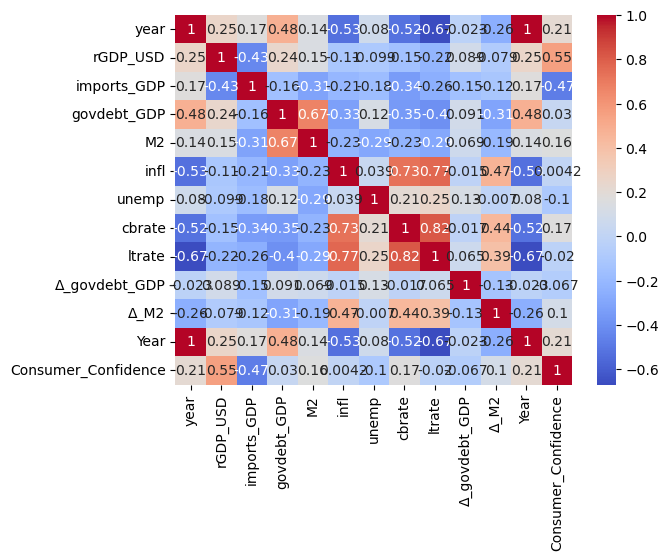

In [12]:
df_filtered_numeric = merged_df.select_dtypes(include=[np.number])

sns.heatmap(df_filtered_numeric.corr(), annot=True, cmap='coolwarm')
plt.show()

Variables with over |.15| correlation --> Just for inital data exploration
rGDP & importsGDP --> Not surprising: more $, more imports
rGDP & govdebt -> Rich 'exceptionalism', those with bigger economies can afford debt
govdebt & LT_Rate, cbRate, infl --> Not Δ, but this could be important for FTPL
infl & cbrate, lt_rate --> adjusts for value, is expected
unemp & lt_rate --> Postive, expected, following phillips curve


To Do:
Identify Countries as developed or developing 

Identify if the information for consumer sentimenet is 'contained' within all other datapoints
    --> Indexed? Percent Change? normalization?

Scale all variables

Use KNN to determine bins
    --> before or after normalization?

In [13]:
descriptive_stats = df_filtered_numeric.describe()

In [14]:
df_filtered = merged_df
len(df_filtered)

574

In [15]:
df_filtered = df_filtered[df_filtered['year'] <= 2019]
len(df_filtered)

549

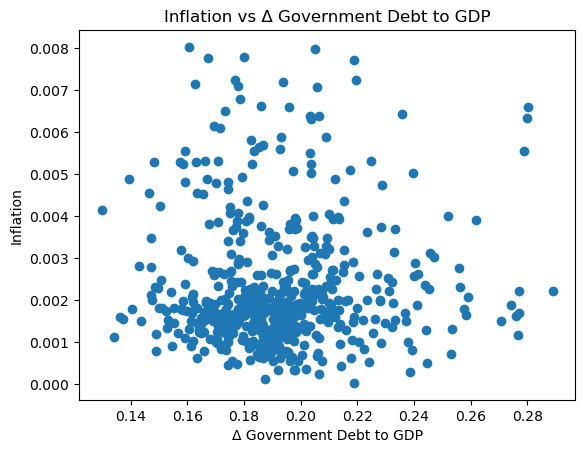

In [16]:
plt.scatter(df_filtered['Δ_govdebt_GDP'], df_filtered['infl'])
plt.xlabel('Δ Government Debt to GDP')
plt.ylabel('Inflation')
plt.title('Inflation vs Δ Government Debt to GDP')
plt.show()

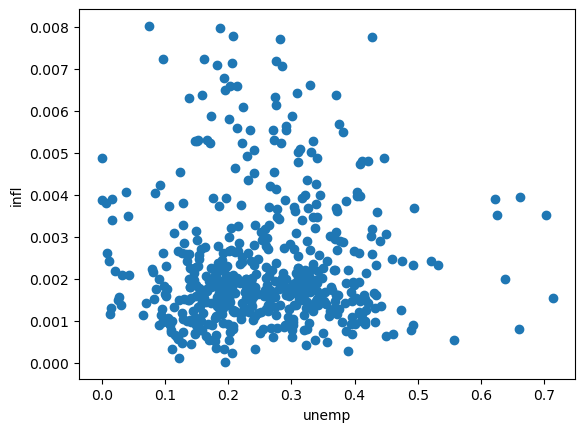

In [17]:
plt.scatter(df_filtered['unemp'], df_filtered['infl'])
plt.ylabel('infl')
plt.xlabel('unemp')
plt.show()

## Hide


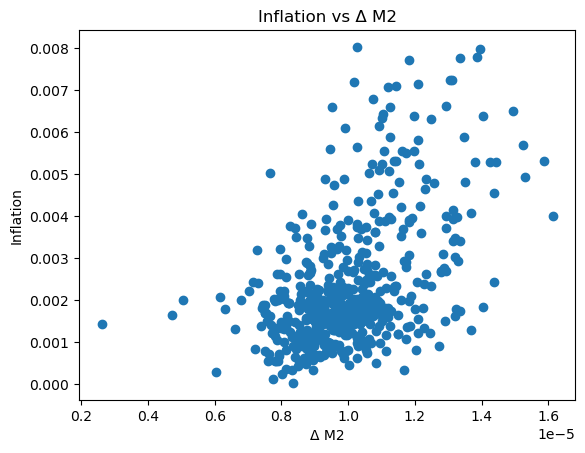

In [18]:
plt.scatter(df_filtered['Δ_M2'], df_filtered['infl'])   
plt.xlabel('Δ M2')
plt.ylabel('Inflation')
plt.title('Inflation vs Δ M2')
plt.show()

In [19]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["Variable"] = df_filtered_numeric.columns
vif_data["VIF"] = [variance_inflation_factor(df_filtered_numeric.values, i) for i in range(len(df_filtered_numeric.columns))]

vif_data

,Variable,VIF
0,year,166.063881
1,rGDP_USD,2.188694
2,imports_GDP,2.544190
3,govdebt_GDP,3.880338
4,M2,3.831946
5,infl,3.138763
6,unemp,2.183013
7,cbrate,4.016369
8,ltrate,5.532313
9,Δ_govdebt_GDP,1.112040


In [20]:
merged_df.shape[0]

574

In [21]:
df_years = merged_df[merged_df['year'] >= 1900]
df_years.shape[0]

574

# Regression to determine 'Information Inclusion' of Consumer Sentiment

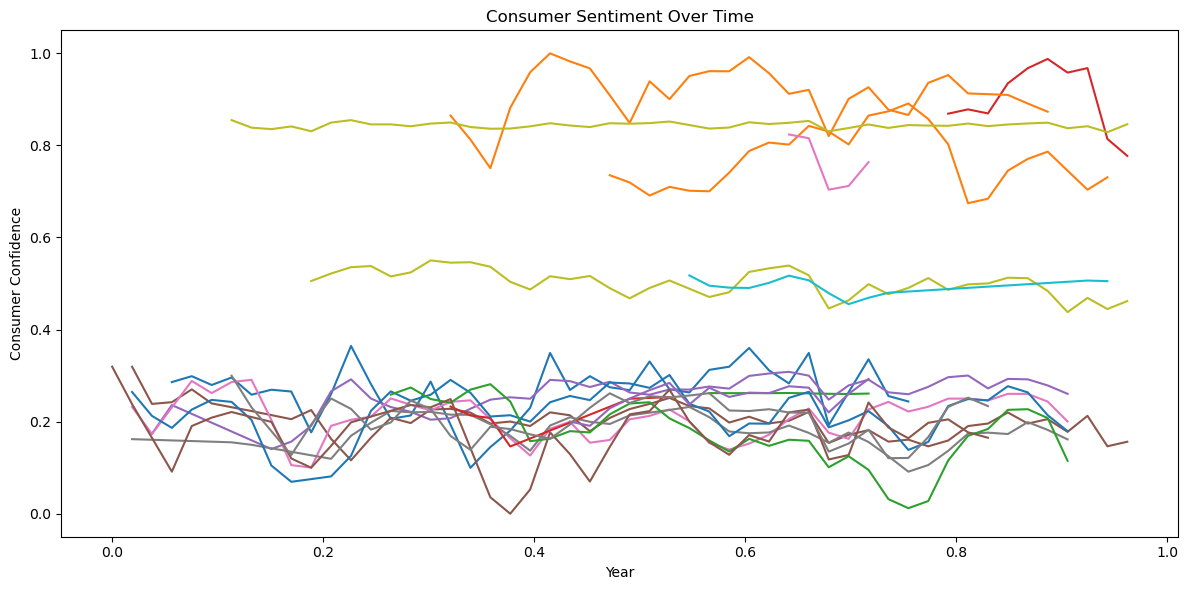

In [22]:
plt.figure(figsize=(12, 6))
for country in merged_df['Country'].unique():
    country_data = merged_df[merged_df['Country'] == country]
    plt.plot(country_data['Year'], country_data['Consumer_Confidence'], label=country)

plt.xlabel('Year')
plt.ylabel('Consumer Confidence')
plt.title('Consumer Sentiment Over Time')
plt.tight_layout()
plt.show()

In [23]:
X = merged_df.drop(columns=['Country', 'Year', 'Consumer_Confidence', 'Consumer_Confidence_Indexed'])
y = merged_df['Consumer_Confidence_Indexed']
y = y.loc[X.index]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=82)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(mse)
print(r2)

KeyError: "['Consumer_Confidence_Indexed'] not found in axis"

Conclusion: Don't have nearly enough information, could try another way, bt I think that this is a good baseline.

# Causal Forest

In [30]:
from econml.dml import CausalForestDML
from econml.sklearn_extensions.linear_model import WeightedLassoCVWrapper, WeightedLasso

In [31]:
import numpy as np
from itertools import product
from sklearn.linear_model import Lasso, LogisticRegression
import matplotlib.pyplot as plt
import os
import pandas as pd
import urllib.request
from sklearn.preprocessing import StandardScaler

In [32]:
n_trees = 1000
min_leaf_size = 50
max_depth = 20
subsample_ratio = 0.04

In [33]:
merged_df = merged_df.dropna()

In [34]:
Y = merged_df['infl']
T = merged_df['infl']
scaler = StandardScaler()

W1 = scaler.fit_transform(merged_df[['imports_GDP', 'Δ_govdebt_GDP', 'Δ_M2', 'cbrate', 'ltrate', 'rGDP_USD' ,'Consumer_Confidence']])
X1 = merged_df[['unemp']]

W2 = scaler.fit_transform(merged_df[['imports_GDP', 'unemp', 'Δ_M2', 'cbrate', 'ltrate', 'rGDP_USD' ,'Consumer_Confidence']])
X2 = merged_df[['Δ_govdebt_GDP']]

W3 = scaler.fit_transform(merged_df[['imports_GDP', 'unemp', 'Δ_govdebt_GDP', 'cbrate', 'ltrate', 'rGDP_USD' ,'Consumer_Confidence']])
X3 = merged_df[['Δ_M2']]

In [35]:
est = CausalForestDML(model_y=WeightedLassoCVWrapper(cv=3, n_jobs=-1, random_state=123),
                        model_t=WeightedLasso(alpha=0.01),
                        discrete_treatment=False,
                        n_estimators=n_trees,
                        min_samples_leaf=min_leaf_size,
                        max_depth=max_depth,
                        random_state=123)


In [36]:
NK_Tree = est.fit(Y,T,X=X1, W=W1)
FTPL_Tree = est.fit(Y,T,X=X2, W=W2)
M_Tree = est.fit(Y, T, X=X3, W=W3)




Model <econml.sklearn_extensions.linear_model.WeightedLassoCVWrapper object at 0x308498a90> has a non-default cv attribute, which will be ignored
Model <econml.sklearn_extensions.linear_model.WeightedLassoCVWrapper object at 0x14f740a50> has a non-default cv attribute, which will be ignored
Model <econml.sklearn_extensions.linear_model.WeightedLassoCVWrapper object at 0x14f742e90> has a non-default cv attribute, which will be ignored


In [52]:
est.effect(X1)




array([0.37184368, 0.37184368, 0.37184368, 0.37184368, 0.37184368,
       0.37184368, 0.37184368, 0.37184368, 0.37184368, 0.37184368,
       0.37184368, 0.37184368, 0.37184368, 0.37184368, 0.37184368,
       0.37184368, 0.37184368, 0.37184368, 0.37184368, 0.37184368,
       0.37184368, 0.37184368, 0.37184368, 0.37184368, 0.37184368,
       0.37184368, 0.37184368, 0.37184368, 0.37184368, 0.37184368,
       0.37184368, 0.37184368, 0.37184368, 0.37184368, 0.37184368,
       0.37184368, 0.37184368, 0.37184368, 0.37184368, 0.37184368,
       0.37184368, 0.37184368, 0.37184368, 0.37184368, 0.37184368,
       0.37184368, 0.37184368, 0.37184368, 0.37184368, 0.37184368,
       0.37184368, 0.37184368, 0.37184368, 0.37184368, 0.37184368,
       0.37184368, 0.37184368, 0.37184368, 0.37184368, 0.37184368,
       0.37184368, 0.37184368, 0.37184368, 0.37184368, 0.37184368,
       0.37184368, 0.37184368, 0.37184368, 0.37184368, 0.37184368,
       0.37184368, 0.37184368, 0.37184368, 0.37184368, 0.37184

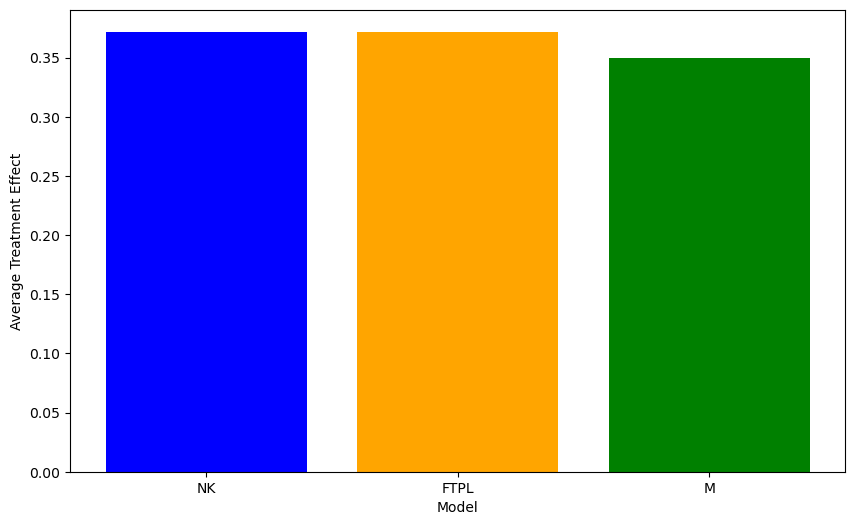

In [41]:
NK_ATE = NK_Tree.ate(X1)
FTPL_ATE = FTPL_Tree.ate(X2)
M_ATE = M_Tree.ate(X3)

plt.figure(figsize=(10, 6))
plt.bar(['NK', 'FTPL', 'M'], [NK_ATE, FTPL_ATE, M_ATE], color=['blue', 'orange', 'green'])
plt.xlabel('Model')
plt.ylabel('Average Treatment Effect')
plt.show()


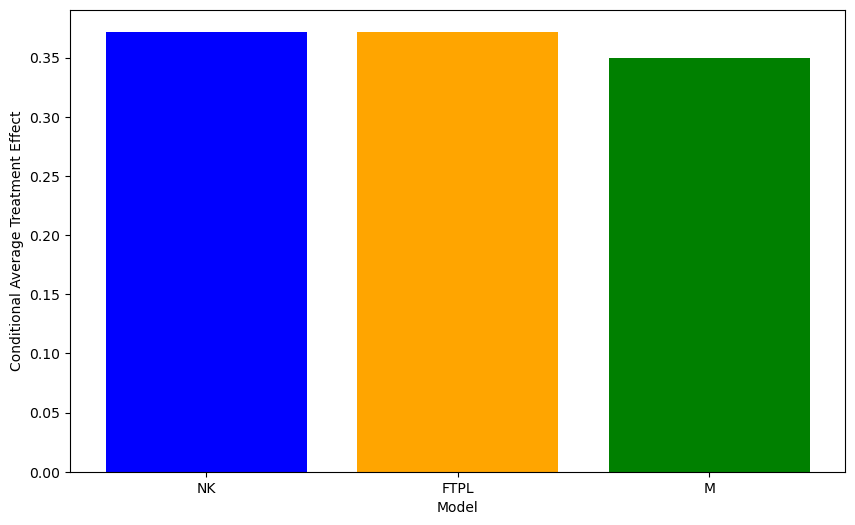

In [43]:
NK_CATE = NK_Tree.effect(X1).mean()
FTPL_CATE = FTPL_Tree.effect(X2).mean()
M_CATE = M_Tree.effect(X3).mean()

plt.figure(figsize=(10, 6))
plt.bar(['NK', 'FTPL', 'M'], [NK_CATE, FTPL_CATE, M_CATE], color=['blue', 'orange', 'green'])
plt.xlabel('Model')
plt.ylabel('Conditional Average Treatment Effect')
plt.show()


In [44]:
NK_feature_importance = NK_Tree.feature_importances_
FTPL_feature_importance = FTPL_Tree.feature_importances_
M_feature_importance = M_Tree.feature_importances_


In [168]:
bin_edges = [-np.inf,0, 5, 20, 50, np.inf]  # Inflation bin ranges
bin_labels = ['Disinflation', 'Target', 'Moderate', 'High','Hyperinflation']  # Inflation bin labels
merged_df['inflation_bin'] = pd.cut(merged_df['infl'], bins=bin_edges, labels=bin_labels)

X_knn = merged_df[['imports_GDP', 'Δ_govdebt_GDP', 'Δ_M2', 'unemp', 'cbrate', 'ltrate', 'rGDP_USD']]
Y_knn = merged_df['inflation_bin']

label_encoder = LabelEncoder()
Y_knn_encoded = label_encoder.fit_transform(Y_knn)

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_knn, Y_knn_encoded)

merged_df['knn_pred_bin'] = knn_model.predict(X_knn)
